In [1]:
!pip3 install ColabTurtlePlus

Defaulting to user installation because normal site-packages is not writeable
  Using cached ColabTurtlePlus-2.0.1-py3-none-any.whl (31 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plt
import re
from ColabTurtlePlus import Turtle as t
import IPython

Put clearscreen() as the first line in a cell (after the import command) to re-run turtle commands in the cell


# Formal semantics

In the past few weeks, we have set up a picture where the mind encodes categories and other stuff with a Language of Thought, we have seen how we can formally define languages, and we have explored how they can be interpreted. However, you might not have realized yet how powerful these methods are in what they can express. This week, we'll put it all together and see some case studies: a simple grammar for arithmetic, a grammar of shapes, and a grammar of sounds. 

Let's start by defining a couple of useful functions (can ignore them for now and have a look when you encounter them below):

In [48]:
def normalize(arr):
    # Transform the array so that it sums to 1
    return arr / np.sum(arr)


def apply_rule(NTS, grammar):
    """
    NTS is a non-terminal symbol, to be expanded by the grammar.
    Accepts both PCFGs (where the keys of grammar
    are lists of tuples (unnormalized prob, right hand side)
    and CFGs (where the keys are lists of right hand side strings.
    """
    match_txt = grammar[NTS]
    try:
        # if PCFG
        probs, subs = zip(*match_txt)
    except ValueError:
        # if CFG
        subs = match_txt
        probs = [1]*len(subs)
    sub = choice(subs, p=normalize(probs))
    return sub

## Basic arithmetic as a CFG

### A simple grammar

Before we get onto interpreting sentences from the grammar, we need a grammar to produce sentences with. For simplicity, we will encode the language as a dictionary. The keys are the left-hand side of substitution rules, the values a list of possible right-hand sides. 

> __NOTE__ We will put non-terminals between angle brackets, e.g. `'<S>'` to simplify parsing the strings.

Let's construct a very simple grammar:

In [4]:
CFG_arithmetic = {
    '<S>': ['plusOne(<S>)', 'one']
}

'plusOne(<S>)'

While `apply_rule` applies a single rule only once, we will also need some way of generating random strings from the grammar (by repeatedly applying rules for all non-terminal symbols):

In [5]:
def complete(sentence, grammar):
    # if there are still '<' that means there are still nonterminals
    while '<' in sentence:
        # substitute the first nonterminal applying 
        # one of the rules in the grammar
        sentence = re.sub(
            # Greedy search of an expression between
            # angle brackets.
            '<(.*?)>', 
            lambda match: apply_rule(match.group(0), grammar), 
            sentence
        )
    return sentence

So for example let's produce a random string:

In [6]:
complete('<S>', CFG_arithmetic)

'plusOne(one)'

Note that even though we have a sentence now and we have an _intuitive_ sense of what it could mean, we still need a way of implementing the interpretation in python. So let's do that!

### Interpreting the grammar

We will use $\lambda$ expressions to encode the meaning of our operators. Thankfully this is made quite easy by Python's lambda syntax, which we have seen a couple of weeks ago. We want to interpret the very simple arithmetic language defined above. We assume a type system with:
- One primitive type $n$, the type of integers.
- Function types defined inductively: $\langle \alpha, \beta \rangle$ is the set of functions from things of type $\alpha$ to things of type $\beta$.

We can give meanings to all the terminals in our language. We do this in a dictionary: the keys are the terminals of our grammar and the values are the meanings, written as $\lambda$ expressions:

In [7]:
meanings = {
    # type n
    'one': 1,
    # type <n,n>
    'plusOne': lambda x: x+1
}

Our primitives can be applied to each other in a way consistent with their types:

In [8]:
# n to n
meanings['plusOne'](
    # n to n
    meanings['plusOne'](
        # n
        meanings['one']
    )
)

3

If the primitives in the language are defined, we can also write a string in the language as a python string, e.g., `'plusOne(one)'`. This is useful when e.g. building random strings from the language. However, we need a way to go from the string to the _interpreted_ string. For this, we exploit python's own interpreter via the keyword `eval`. Python's `eval` function plays the role of the interpretation function which we discussed in class, but it allows us to not take care of parsing brackets (going from a string to the underlying parse tree to interpret).

> __NOTE__ It is generally not recommended to use Python's `eval`. We will use it here only to evaluate sentences in our hand-made grammars, but never let it evaluate something you don't understand! We can pass `meanings` as the second argument of `eval` to tell it which symbols to interpret.

Let's see a simple example:

In [9]:
eval('plusOne(plusOne(one))', meanings)

3

Now we have a way of generating random strings from our gramnmar, as well as interpreting them. Therefore, we can study what happens when we produce a bunch of random strings. For instance, we can ask: what's the distribution of numbers produced by our PCFG?

In [10]:
# plot distribution of numbers obtained with this grammar
numbers = [
    eval(complete('<S>', CFG_arithmetic), meanings) 
    for _ in range(10000)
]

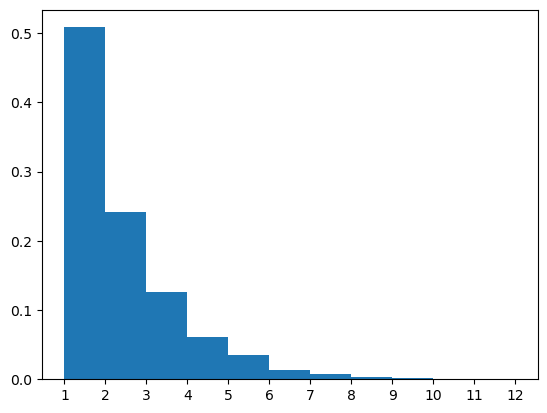

In [11]:
plt.hist(numbers, density=True, bins=np.arange(1,13))
plt.xticks(np.arange(1, 13))
plt.show()

Turns out the probability of each number $n$ is $2^{-n}$. Can you tell why?

### From a CFG to a PCFG

In practice, we'll mostly work with _probabilistic_ context free grammars. The idea here is that for each nonterminal we specify the probability of each possible substitution. A natural way of doing this here is, instead of having simply a list of possible substitutions as the value of the grammar dictionary, we have a list of tuples. The first element of each tuple is the (unnormalized) probability of that substitution rule, the second element is the actual right-hand side. 

Applying this to our simple arithmetic grammar above:

In [12]:
CFG_arithmetic = {
    '<S>': [
        (1, 'plusOne(<S>)'), 
        (1, 'one')
    ]
}

Our function `complete` still works, but now applies substitution rules with the given probabilities:

In [13]:
complete('<S>', CFG_arithmetic)

'plusOne(plusOne(plusOne(plusOne(one))))'

### Expanding the grammar

Our simple arithmetical grammar is cool and all, but extremely small. Let's enrich it slightly:

In [14]:
CFG_arithmetic = {
    '<S>': [
        (1, 'plusOne(<S>)'), 
        (1, 'one'),
        # NEW!
        (0.3, 'plus(<S>)(<S>)'),
        (0.3, 'minus(<S>)(<S>)')
    ]
}

In [15]:
CFG_arithmetic

{'<S>': [(1, 'plusOne(<S>)'),
  (1, 'one'),
  (0.3, 'plus(<S>)(<S>)'),
  (0.3, 'minus(<S>)(<S>)')]}

We also need to add the meaning of the new terminals:

In [16]:
# type <n,<n,n>>
meanings['plus'] = lambda x: lambda y: x + y
# type <n,<n,n>>
meanings['minus'] = lambda x: lambda y: x - y

Make sure that we can interpret the strings produces by the expanded grammar:

In [17]:
eval('plus(plusOne(plusOne(one)))(plusOne(one))', meanings)

5

Let's produce a bunch of sentences in the new grammar and see what distribution their interpretation takes:

In [18]:
# plot distribution of numbers obtained with this grammar
numbers = [
    eval(complete('<S>', CFG_arithmetic), meanings) 
    for _ in range(10000)
]

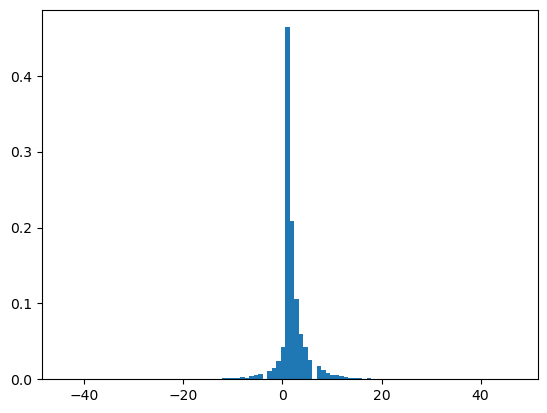

In [19]:
plt.hist(numbers, density=True, bins=100)
plt.show()

## A grammar for shapes

Instead of defining meanings ourselves, we can rely on already existing libraries, even if they were not meant to be used with a CFG. For instance, consider Python's 'turtle' library. The idea is very simple: Imagine a little turtle that moves around the screen according to certain instructions, and as it moves around it traces a line. Instructions are things like 'move forward', 'go around some of a circle', etc.

Here's an example to show you the syntax:

In [20]:
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
for i in range(20):
    t.forward(10)
    t.circle(20,60)
    t.right(90)
    t.forward(30)

Based on these movements, we can define a grammar that produces series of instructions and just use the meanings defined by the Turtle library:

In [21]:
grammar = {
    # always start with a drawing
    '<drawing>': [
        # a drawing can include a movement 
        # follows by a drawing (recursive!)
        (8, '\t<movement>\n<drawing>'),
        # at some point the drawing ends
        (1, '\tpass'),
    ],
    # a movement is basically a single instruction
    # so a drawing consists of a series of movements
    # Movements have two types of parameters,
    # namely: angles and distances
    '<movement>': [
        (1, 't.forward(<distance>)'),
        (1, 't.backward(<distance>)'),
        (1, 't.right(<angle>)'),
        (1, 't.left(<angle>)'),
        (1, 't.circle(<distance>,<angle>)')
    ],
    # hand-specify some distances
    '<distance>': [
        (1, '10'),
        (1, '20'),
        (1, '30'),
    ],
    # hand-specify some angles
    '<angle>': [
        (1, '30'),
        (1, '60'),
        (1, '90'),
        (1, '170')
    ]
}

Try to run this multiple times and note that sometimes the result is just empty or a straight line, and sometimes it is some interesting complex shapes:

In [22]:
# define the 'central' part of the instructions
instructions = complete('<drawing>', grammar)

# add some needed scaffolding
program = f"""
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
for i in range(20):
{instructions}
"""

exec(program)

In [23]:
print(program)


t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
for i in range(20):
	t.left(90)
	pass



The point here is: each sentence in our grammar is a shape.

If we take the LoT hypothesis seriously, we can then think that shape concepts (squares, triangles, etc.) are encoded at the cognitive level as sentences in the geometric fragment of the LoT.

## A grammar for music

In [26]:
# define rate (don't worry about this!)
fs = 44100

Another fascinating domain of interest for cognitive science is that of sounds. Let's think of what a simple grammar for sounds could be like. We are going to need a way of defining notes given a frequency:

In [27]:
def defineNote(frequency, seconds, fs=44100):
    # seconds*sample_rate steps 
    # between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)
    # sine wave
    note = np.sin(frequency * t * 2 * np.pi)
    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)
    return audio

And a way of playing them:

In [29]:
IPython.display.Audio(
    # put note or notes here!
    defineNote(220, 1), 
    rate=fs, 
    autoplay=True
)

We'll also need a way of melting two notes, i.e. playing them together:

In [33]:
def melt(note1, note2):
    # if they are of different lengths,
    # pad the shorter one with 0s
    diff = len(note1) - len(note2)
    if diff < 0:
        note1 = np.concatenate((
            note1,
            np.zeros(-diff, dtype=int)
        ))
    elif diff >= 0:
        note2 = np.concatenate((
            note2,
            np.zeros(diff, dtype=int)
        ))

    return note1 + note2

Test the function:

In [34]:
melted = melt(
    defineNote(220, 1),
    defineNote(440, 1)
)

IPython.display.Audio(
    melted, 
    rate=fs, 
    autoplay=True
)

And a way of appending one note to another one:

In [38]:
def successive(note1, note2):
    return np.concatenate((note1, note2))

Define each note in an octave, so we can call them by name:

In [39]:
freqs = {
    'A': 220,
    'Bb': 233.08,
    'B': 246.94,
    'C': 261.63,
    'Db': 277.18,
    'D': 293.66,
    'Eb': 311.13,
    'E': 329.63,
    'F': 349.23,
    'Gb': 369.99,
    'G': 392.00,
    'Ab': 415.30,
}

And finally collect all the primitive meanings we defined in a single dictionary, so that we can use it with `interpret` to get the meaning of each sentence produced by the grammar:

In [40]:
interpret = {
    **freqs,
    'defineNote': defineNote,
    'melt': melt,
    'successive': successive 
}

Now we are ready to define a very simple grammar of music:

In [41]:
soundGrammar = {
    '<tune>': [
        (2, '<note>'),
        (1, 'successive(<tune>, <tune>)'),
        (1, 'melt(<tune>, <tune>)')
    ],
    '<note>': [
        (1, 'defineNote(<freq>, <time>)')
    ],
    '<freq>': list(freqs.keys()),
    '<time>': [
        (2, '0.1'), 
        (1, '0.2'), 
        (1, '0.3'),
    ]
}

In [42]:
soundGrammar

{'<tune>': [(2, '<note>'),
  (1, 'successive(<tune>, <tune>)'),
  (1, 'melt(<tune>, <tune>)')],
 '<note>': [(1, 'defineNote(<freq>, <time>)')],
 '<freq>': ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab'],
 '<time>': [(2, '0.1'), (1, '0.2'), (1, '0.3')]}

Run this until you get something long that looks interesting! As in the geometric example above, some productions are very simple while others are very messy and complicated.

In [46]:
tune = complete('<tune>', soundGrammar)
print(tune)

melt(defineNote(B, 0.2), melt(melt(defineNote(Eb, 0.3), melt(successive(defineNote(Ab, 0.3), defineNote(F, 0.1)), melt(defineNote(D, 0.3), defineNote(C, 0.2)))), defineNote(Eb, 0.1)))


In [47]:
IPython.display.Audio(
    # put note or notes here!
    eval(tune, interpret), 
    rate=fs, 
    autoplay=True
)

This is not going to sound very good, possibly because the grammar is not encoding any of the interesting structure we like in music. 

> __QUESTION__ How do you think we could modify the grammar to make the productions more aesthetically pleasant / less 'messy' sounding?

## Homework

Second homework set! Here's the task: 
1. Pick a domain. You are free to pick the domain you want, but here are some ideas (in increasing complexity):
    - Polynomials: Each sentence produced by the grammar then is a polynomial function of one variable `x`. Polynomials have a fixed structure that can be described by a grammar & can be easily plotted with plt!
    - 2d polynomials: A polynomial function of two variables. It can be displayed as a surface. The only difference is that now you have two variables instead of just one. For plotting you can use e.g. [this plt function](https://matplotlib.org/stable/gallery/mplot3d/surface3d.html).
    - Trees: this can be done in turtle, e.g. see [this example](https://stackoverflow.com/questions/39822733/turtle-and-draw-a-tree-with-transcrypt), but you need to be careful about lines going up, otherwise it's not a tree! :)
    - Towers (more ambitious)
        - Basically, blocks of different shapes and sizes (or just one shape and size to start with) put on top of each other.
        - Each sentence in the grammar would be a tower. Something like `place_on_top(position=0.5, bottomblock=block(h=2,w=3), topblock=block(h=3,w=2))` for a simple tower with two blocks.
        - The tricky thing is going to be to make sure you don't get overlapping blocks, or to find a good way of dealing with overlapping blocks. Some possible ways of dealing with this at the interpreter level: (1) whenever two blocks overlap, fuse them with each other, (2) if a block overlap with an already defined block, chop off the overlapping part, (3) if a block overlap with an already defined block, don't add the new proposed block but keep going.
        - Towers can be rendered visually with matplotlib
        - In fact, it shouldn't be too hard with [pymunk](http://www.pymunk.org/en/latest/) to run the time forward and see if you can get more stable towers / higher towers by picking the right grammar ;) 
        - Exploring this more could be a final project for instance!
        - See the code below for some initial scaffolding.
1. Write a grammar that produces descriptions of objects in that domain
    - Like the geometric grammar and the sound grammar above.
1. Write an interpreter for that grammar
    - Feel free to rely on pre-existing libraries for this if you'd like, like we did above with turtle.
1. Produce and interpret some sentences from the grammar and display some examples.
    - What it means to 'display' depends on the domain you chose. For instance, it can be a picture, an audio, or a video. But also just a number or something else!

In this lab we have seen how to do this for three domains (numbers, geometrical shapes, sounds), which should give you an idea of how it's done.

## (Optional: some initial code for tower grammar)

In [2]:
!pip install pymunk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.5/979.5 KB 7.6 MB/s eta 0:00:0000:0100:01


In [218]:
import pymunk
from pymunk import Vec2d
from IPython.display import HTML

I thought I would help you out if you decide to do the tower thing and animate it. Here's some useful objects:

In [326]:
def calculate_coords(block):
    """
    This function takes a pymunk's Body object
    and returns a list containing the current 
    position of its vertices in global coordinates
    """
    shape = list(block.shapes)[0]
    return [
        list(v.rotated(shape.body.angle) + shape.body.position)
        for v in shape.get_vertices()
    ]


class Tower:
    """
    This class models a tower, i.e. a bunch of blocks.
    We can add a new block with the function add_block
    """
    
    def __init__(self):

        ### Init pymunk and create space
        self.space = pymunk.Space()
        self.space.gravity = (0.0, -100)
        
        ### Add ground
        shape = pymunk.Segment(
            self.space.static_body, 
            (0, -1), 
            (10, -1), 
            1.0
        )
        shape.friction = 1.0
        self.space.add(shape)

    def add_block(self, pos, size, mass=1.):
        """
        Parameters
        ----------
        pos: tuple
            The (x,y) position of the center of the block
            NOTE: Center of mass is at local coordinate's (0,0)
        size: tuple
            Width and height of block respectively
        si
        """
        width, height = size
        # sequential edges of polygon 
        # in *local* coordinates
        vs = [(-width/2, -height/2), (width/2, -height/2), (width/2, height/2), (-width/2, height/2)]
        moment = pymunk.moment_for_poly(mass, vs, (0, 0))
        block = pymunk.Body(mass, moment)
        block.position = pos
        shape = pymunk.Poly(block, vs)
        shape.friction = 10
        self.space.add(block, shape)

    def loop(self):
        """
        Generates the successive positions of all blocks
        """
        fps = 30.0
        dt = 1.0 / fps / 5
        while True:
            self.space.step(dt)
            yield [
                calculate_coords(block) 
                for block in self.space.bodies
            ]

And the code for simulating the physical behaviour of the tower over time with plt:

In [321]:
import matplotlib.animation as anim
from matplotlib.patches import Polygon

def plot_cont(return_positions_f):
    y = []
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    def update(blocks_coords):
        ax.clear()
        for block_coords in blocks_coords:
            # print(block_coords)
            p = Polygon(
                block_coords, 
                edgecolor='k',
                facecolor='w'
            )
            ax.add_patch(p)
        ax.set_ylim(0,10)
        ax.set_xlim(0,10)

    a = anim.FuncAnimation(fig, update, frames=return_positions_f, repeat=False)
    return a

And finally let's check this with a simple example of an unstable tower:

In [327]:
tower = Tower()
tower.add_block([1,0.5], (1,1))
tower.add_block([1.55,1.5], (1,1))

In [328]:
%%capture
a = plot_cont(tower.loop)

In [329]:
HTML(a.to_html5_video())